In [1]:
from typing import Any, OrderedDict, List, Dict
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import resnet50
from torchvision.io import read_image
from torchvision.transforms import v2 as T
from omegaconf import DictConfig
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import json

## Load Data

In [2]:
class ImageDataset(Dataset):
    def __init__(self, set_map: List[Dict], transform=None) -> None:
        ''' Each item in set_map is expected to contain:
                img_path: Full path to image,
                label: Label corresponding to image at img_path
        '''

        self.set_map = set_map
        self.transform=transform

    def __len__(self):
        return len(self.set_map)
    
    def __getitem__(self, index):   
        sample = self.set_map[index]

        image = read_image(sample['img_path'])

        if self.transform:
            image = self.transform(image)

        return dict(image=image, **sample)

In [3]:
with open('./data/train.json', 'r') as file:
    train_set_map = json.load(file)

In [4]:
with open('./data/test.json', 'r') as file:
    test_set_map = json.load(file)

In [5]:
label_map = {
    'DGG': 0,
    'PH': 1,
    'EH': 2
}

domain_map = {
    'cartoon': 0,
    'art_painting': 1,
    'photo': 2,
}

In [6]:
for elem in train_set_map:
    elem['label'] = label_map[elem['label']]
for elem in test_set_map:
    elem['label'] = label_map[elem['label']]

In [11]:
train_set_map

[{'img_path': './data/PACS/art_painting/dog/pic_247.jpg',
  'label': 0,
  'domain': 'art_painting'},
 {'img_path': './data/PACS/photo/person/253_0271.jpg',
  'label': 1,
  'domain': 'photo'},
 {'img_path': './data/PACS/cartoon/elephant/pic_288.jpg',
  'label': 2,
  'domain': 'cartoon'},
 {'img_path': './data/PACS/art_painting/giraffe/pic_090.jpg',
  'label': 0,
  'domain': 'art_painting'},
 {'img_path': './data/PACS/art_painting/elephant/pic_035.jpg',
  'label': 2,
  'domain': 'art_painting'},
 {'img_path': './data/PACS/photo/person/253_0400.jpg',
  'label': 1,
  'domain': 'photo'},
 {'img_path': './data/PACS/art_painting/guitar/pic_143.jpg',
  'label': 0,
  'domain': 'art_painting'},
 {'img_path': './data/PACS/art_painting/guitar/pic_117.jpg',
  'label': 0,
  'domain': 'art_painting'},
 {'img_path': './data/PACS/art_painting/giraffe/pic_002.jpg',
  'label': 0,
  'domain': 'art_painting'},
 {'img_path': './data/PACS/cartoon/elephant/pic_253.jpg',
  'label': 2,
  'domain': 'cartoon'},
 

In [7]:
# TODO: match pretraining transform
transform = T.Compose([
    T.Resize(size=(96,96)),
    T.ToDtype(torch.float32),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_set = ImageDataset(train_set_map, transform=transform)
test_set = ImageDataset(test_set_map, transform=transform)

In [9]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
test_set = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

## Validate Data

In [10]:
stats = {}
for elem in train_set_map:
    domain = elem['domain']
    label = elem['label']

    if domain not in stats.keys() :
        stats[domain] = {}

    if label not in stats[domain].keys():
        stats[domain][label] = 1
    else:
        stats[domain][label] += 1

In [12]:
stats

{'art_painting': {0: 771, 2: 77, 1: 77},
 'photo': {1: 641, 2: 64, 0: 64},
 'cartoon': {2: 696, 1: 70, 0: 70}}

In [13]:
stats = {}
for elem in test_set_map:
    domain = elem['domain']
    label = elem['label']

    if domain not in stats.keys() :
        stats[domain] = {}

    if label not in stats[domain].keys():
        stats[domain][label] = 1
    else:
        stats[domain][label] += 1

In [14]:
stats

{'cartoon': {2: 85, 1: 72, 0: 82},
 'art_painting': {1: 75, 0: 77, 2: 41},
 'photo': {1: 71, 2: 46, 0: 58}}

## Train Models

In [15]:
import pytorch_lightning as L

In [16]:
class LinearProbe(L.LightningModule):
    def __init__(self, backbone, emb_dim, num_classes, lr=1e-4) -> None:
        super().__init__()
        
        self.backbone: nn.Module = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.linear_head: nn.Module = nn.Linear(emb_dim, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        x = self.backbone(x)
        x = self.linear_head(x)

        return x

    def training_step(self, batch, bacth_idx):
        X = batch['image']
        t = batch['label']

        y = self.forward(X)
        loss = self.criterion(y, t)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [17]:
def get_backbone_from_ckpt(ckpt_path: str) -> torch.nn.Module:
    state_dict = torch.load(ckpt_path)["state_dict"]
    state_dict = OrderedDict([
        (".".join(name.split(".")[1:]), param) for name, param in state_dict.items() if name.startswith("backbone")
    ])

    return state_dict

In [18]:
# Baseline Model
model_bl  = resnet50()
weights_bl = get_backbone_from_ckpt("./r50_bt.ckpt")
model_bl.load_state_dict(weights_bl, strict=False)
model_bl.fc = torch.nn.Identity()
model_bl = model_bl.cuda()

In [19]:
# MixStyle Model
model_ms  = resnet50()
weights_ms = get_backbone_from_ckpt("./r50_bt_ms.ckpt")
model_ms.load_state_dict(weights_ms, strict=False)
model_ms.fc = torch.nn.Identity()
model_ms = model_ms.cuda()

In [20]:
baseline_module = LinearProbe(model_bl, emb_dim=2048, num_classes=3)

In [21]:
mixstyle_module = LinearProbe(model_ms, emb_dim=2048, num_classes=3)

In [22]:
trainer = L.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(baseline_module, train_loader)

/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | backbone    | ResNet           | 23.5 M
1 | linear_head | Linear           | 6.1 K 
2 | criterion   | CrossEntropyLoss | 0     
-------------------------------------------------
6.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/home/yasin/miniforge3/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [21]:
train_set.__getitem__(0)

{'image': tensor([[[ 976.0480,  954.2140,  980.4149,  ..., 1015.3493,  984.7817,
            976.0480],
          [ 941.1135,  919.2795,  958.5807,  ..., 1054.6506, 1045.9170,
           1050.2838],
          [ 997.8821, 1006.6157,  997.8821,  ..., 1080.8516, 1080.8516,
           1089.5851],
          ...,
          [ 971.6812,  945.4803,  936.7467,  ...,  155.0873,  168.1878,
            185.6550],
          [ 967.3144,  945.4803,  928.0131,  ...,  141.9869,  146.3537,
            163.8210],
          [ 984.7817,  962.9476,  941.1135,  ...,  128.8865,  150.7205,
            176.9214]],
 
         [[ 413.1429,  395.2857,  431.0000,  ...,  332.7857,  297.0714,
            301.5357],
          [ 377.4286,  355.1071,  395.2857,  ...,  332.7857,  323.8571,
            323.8571],
          [ 372.9643,  381.8929,  372.9643,  ...,  332.7857,  332.7857,
            328.3214],
          ...,
          [ 462.2500,  444.3929,  448.8571,  ...,  109.5714,  136.3571,
            145.2857],
        

In [ ]:
from pacs_dm import PacsDM

In [ ]:
cfg = DictConfig({
    'data_path': '/data',
    'param': {
        'batch_size': 16
    }
})

In [ ]:
dm = PacsDM(cfg, leave_out=[])
dm.setup('fit')
train_loader = dm.train_dataloader()

In [ ]:
x, t, d = next(iter(train_loader))

In [ ]:
def embed(model, train_loader):
    with torch.no_grad():
        Z, T, D = [], [], []
        for x, t, d in tqdm(train_loader):
            z = model(x.cuda()).detach().cpu()
            Z.append(z)
            T.append(t)
            D.append(d)
        Z = torch.cat(Z, dim=0).contiguous()
        T = torch.cat(T, dim=0).contiguous()
        D = torch.cat(D, dim=0).contiguous()

    return dict(Z=Z, T=T, D=D)

In [ ]:
embeddings = {
    'baseline': embed(model_bl, train_loader),
    'mixstyle': embed(model_ms, train_loader)
}

100%|██████████| 625/625 [00:05<00:00, 109.19it/s]


In [ ]:
def plot_tsne(name, ax, Z, D):
    print('Plotting ...')


    pca = PCA(n_components=15)
    Z = pca.fit_transform(Z)

    Z_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=100).fit_transform(Z)
    ax.scatter(Z_tsne[:,0], Z_tsne[:,1], c=D)

    Z_train, Z_test, D_train, D_test = train_test_split(Z, D, test_size=0.4, random_state=42)

    logreg = LogisticRegression()
    logreg.fit(Z_train, D_train)

    D_pred = logreg.predict(Z_test)
    accuracy = accuracy_score(D_test, D_pred)
    ax.set_title(f"{name} Dom.-Accuracy: {accuracy:.2f}")
    

Plotting ...
Plotting ...


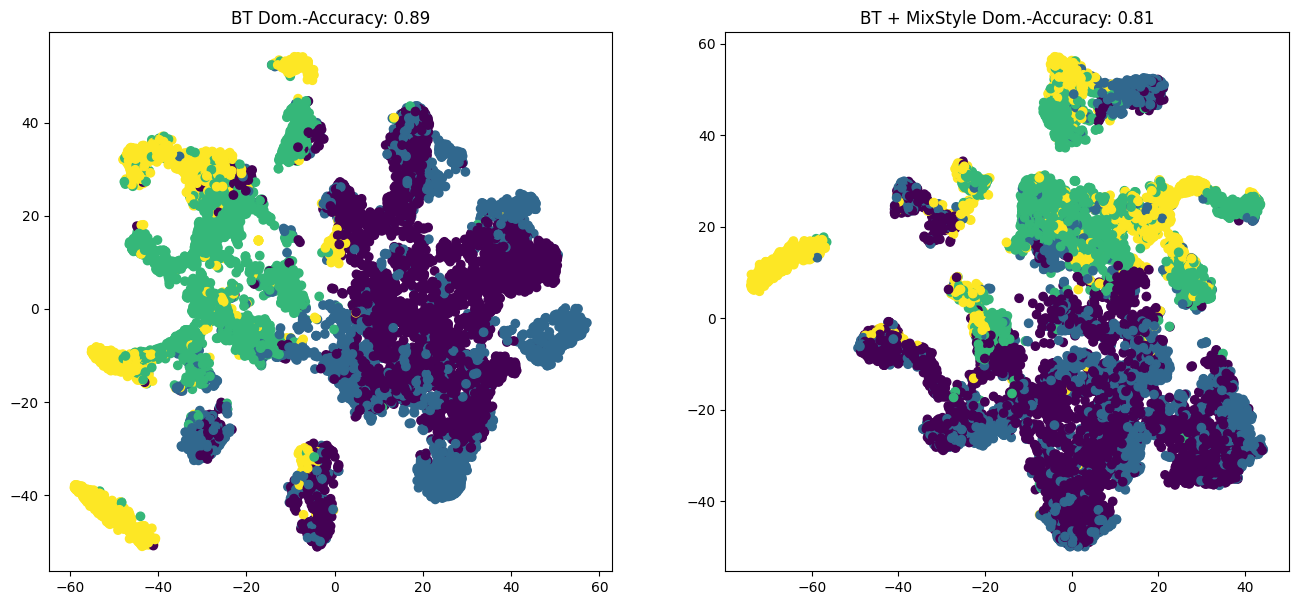

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(7)

plot_tsne('BT', ax1, Z=embeddings['baseline']['Z'], D=embeddings['baseline']['D'])
plot_tsne('BT + MixStyle', ax2, Z=embeddings['mixstyle']['Z'], D=embeddings['mixstyle']['D'])